# ML Modeling with embedded data
- updated 0906  
- data : thd ver3 / ver4

In [ ]:
cd /content/drive/My Drive/빅콘

/content/drive/My Drive/빅콘


In [ ]:
#!apt-get update --qq
#!apt-get install fonts-nanum* -qq

In [ ]:
#import matplotlib.font_manager as fm
#fm._rebuild()

In [ ]:
# ready
import os
import sys
import joblib
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd 
import numpy as np
import random
import math

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('display.max_info_columns', 500)

import imp
import datetime
from tqdm import tqdm

In [ ]:
# vusualize
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)

## Load Data
thd data 사용  
data['X'] / data['y']

In [ ]:
# load data
## ver3
data_v3 = joblib.load(os.path.join('data', 'Thd_FE_ver3_2020090554.pkl'))
locals().update(data_v3)

## ver4
data_v4 = joblib.load(os.path.join('data', 'Thd_FE_ver4_2020090506.pkl'))
locals().update(data_v4)

In [ ]:
data_v3['X'].shape, data_v4['X'].shape

((35379, 381), (35379, 461))

In [ ]:
# make X
X_v3 = data_v3['X']
X_v4 = data_v4['X']
# na
X_v3 = X_v3.fillna(0)
X_v4 = X_v4.fillna(0)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35379 entries, 0 to 38303
Data columns (total 401 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   노출(분)                                               35379 non-null  float64
 1   판매단가                                                35379 non-null  int64  
 2   방송시간차                                               35379 non-null  float64
 3   상품방송횟수                                              35379 non-null  float64
 4   브랜드방송횟수                                             35379 non-null  float64
 5   조기매진                                                35379 non-null  int64  
 6   isHoliday                                           35379 non-null  int64  
 7   방송월                                                 35379 non-null  int64  
 8   방송일                                                 35379 non-null  int64  

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


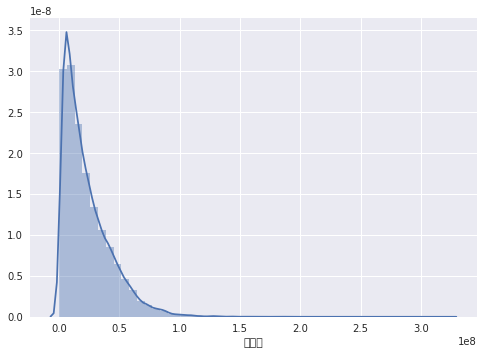

In [ ]:
# target
sns.distplot(data_v3['y'])

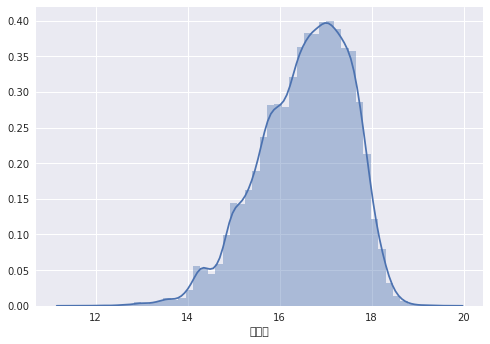

In [ ]:
# log scaling
log_y = np.log(data_v3['y'])
sns.distplot(log_y)

## Modeling

In [ ]:
# ready
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score
import random

### 1. 평가기준 CV

In [ ]:
# mape
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# cv 기반 : jb code
# y는 log 스케일링된 것 넣을 것

def month_cv(X, y, model):
    preds = []
    mapes = []
    
    for i in range(1,13):
        # data split
        # 한달에서도 랜덤 샘플 반 뽑기
        test_idx = random.sample(list(X[X['방송월'] == i].index), math.ceil(len(X[X['방송월'] == i]) / 2))    #올림
        train_idx = set(X.index) - set(test_idx)

        # 월별 train, validation -> n월을 맞추기 위해 나머지 월 모두 들어감
        X_train = X.loc[train_idx]
        y_train = y.loc[train_idx]

        X_test = X.loc[test_idx]
        y_test = y.loc[test_idx]
    
        # model
        model.fit(X_train, y_train)
        y_pred = np.exp(model.predict(X_test))
        preds.append(y_pred)
        
        # 평가
        month_mape = mean_absolute_percentage_error(np.exp(y_test), y_pred)
        mapes.append(month_mape)

        # 월별 pred mean값 출력
        print(np.mean(preds))
    return np.mean(preds), np.mean(mapes)


In [ ]:
# X, y, n_folds 설정해야함
def mape_cv(model,X,y,n_folds):
  kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
  mae = np.abs(-cross_val_score(model, X.values, y, scoring='neg_mean_absolute_error', cv=kf))
  return (mae*(100/sum(y)))

In [ ]:
#month_cv(X,log_y,lr) # dimension error 못잡음

In [ ]:
# TimeSeries Split
# ref https://davinci-ai.tistory.com/18



### 2. Base Modeling with Hypter parameter tunning

|<center>Model</center>|<center>Best Score (MAPE)</center>| <center>비고</center>|
|:--------|:--------|:--------|
| Linear Regression | 0.004213460809426863 | |
| Decision Tree | 0.00010029251349110202 |  |
| KNN | 0.00010200931506572312 | |
| Random Forest | 8.19596488334804e-05 | |
| GBM |  | nan 나옴|
| LGBM | 45.763609593574614 | exponentiol|


* Linear Regression

In [ ]:
lr = LinearRegression()
print(mape_cv(lr, X, log_y, 5))
print('mape : ', np.mean(mape_cv(lr, X, log_y, 5)))

[1.94181798e-02 1.19410033e-04 9.21810709e-05 1.02874033e-04
 1.33465909e-03]
mape :  0.004213460809426863


In [ ]:
month_cv(X, log_y, lr)

* Decision Tree

In [ ]:
dt = DecisionTreeRegressor(max_depth=10)
print(mape_cv(dt, X, log_y, 5))
print('mape : ', np.mean(mape_cv(dt, X, log_y, 5)))

[1.02994363e-04 9.02012706e-05 9.00353400e-05 9.21711874e-05
 1.27876158e-04]
mape :  0.00010029251349110202


In [ ]:
month_cv(X, log_y, dt)

* KNN (비지도라 의미있을 듯)

In [ ]:
knn = KNeighborsRegressor(n_neighbors = 10)
print(mape_cv(knn, X, log_y, 5))
print('mape : ', np.mean(mape_cv(knn, X, log_y, 5)))

[1.03383081e-04 9.65306006e-05 9.84545697e-05 1.02475149e-04
 1.09203175e-04]
mape :  0.00010200931506572312


In [ ]:
month_cv(X, log_y, knn)

* Random Forest (배깅)

In [ ]:
rf = RandomForestRegressor()
print(mape_cv(rf, X, log_y, 5))
print('mape : ', np.mean(mape_cv(rf, X, log_y, 5)))

[8.41661629e-05 7.04736834e-05 6.91249023e-05 7.56797684e-05
 1.10851556e-04]
mape :  8.19596488334804e-05


In [ ]:
month_cv(X, log_y, rf)

* GBM

In [ ]:
# gbm 은 왠지 모르게 nan이 나옵니다^^
gbm = GradientBoostingRegressor(learning_rate = 0.5, max_depth=5, loss='mse')
print(mape_cv(gbm, X, log_y, 5))
print('mape : ', np.mean(mape_cv(gbm, X, log_y, 5)))

[nan nan nan nan nan]
mape :  nan


In [ ]:
month_cv(X, log_y, gbm)

* ML with embedded data ver3 & ver4


In [ ]:
# lr
lr = LinearRegression()
print(mape_cv(lr, X_v3, log_y, 5))
print('mape : ', np.mean(mape_cv(lr, X_v3, log_y, 5)))

print(mape_cv(lr, X_v4, log_y, 5))
print('mape : ', np.mean(mape_cv(lr, X_v4, log_y, 5)))

# dt
dt = DecisionTreeRegressor(max_depth=10)
print(mape_cv(dt, X_v3, log_y, 5))
print('mape : ', np.mean(mape_cv(dt, X_v3, log_y, 5)))

print(mape_cv(dt, X_v4, log_y, 5))
print('mape : ', np.mean(mape_cv(dt, X_v4, log_y, 5)))

# knn
knn = KNeighborsRegressor(n_neighbors = 10)
print(mape_cv(knn, X_v3, log_y, 5))
print('mape : ', np.mean(mape_cv(knn, X_v3, log_y, 5)))

print(mape_cv(knn, X_v4, log_y, 5))
print('mape : ', np.mean(mape_cv(knn, X_v4, log_y, 5)))

# rf
rf = RandomForestRegressor()
print(mape_cv(rf, X_v3, log_y, 5))
print('mape : ', np.mean(mape_cv(rf, X_v3, log_y, 5)))

print(mape_cv(rf, X_v4, log_y, 5))
print('mape : ', np.mean(mape_cv(rf, X_v4, log_y, 5)))

[1.08890950e-04 9.89984328e-05 9.26155223e-05 1.02642621e-04
 1.29337047e-04]
mape :  0.00010649691481245487
[5.29141761e-01 7.85132656e-04 2.13181801e-04 2.22208540e-04
 2.63341239e-03]
mape :  0.1065991392601027
[9.99682966e-05 8.76457224e-05 9.17672801e-05 9.67442606e-05
 1.26095291e-04]
mape :  9.949073060884978e-05
[1.01832424e-04 9.17460859e-05 8.86239695e-05 9.15102622e-05
 1.21590864e-04]
mape :  9.957638129059435e-05
[1.03372703e-04 9.65360271e-05 9.84582907e-05 1.02485262e-04
 1.09180799e-04]
mape :  0.00010200661629457372
[1.03307231e-04 9.65410901e-05 9.84530532e-05 1.02483739e-04
 1.09181656e-04]
mape :  0.00010199335390711277
[8.63208541e-05 7.08299151e-05 6.94085964e-05 7.56502372e-05
 1.09469576e-04]
mape :  8.255893705640249e-05
[8.44887532e-05 6.98022666e-05 6.92078616e-05 7.46344929e-05
 1.08231387e-04]
mape :  8.115331246994583e-05


* LGBM

In [ ]:
# no hyperparameter tuning
lgb_params = {'learning_rate': 0.03, 'max_depth' : 16, 'objective': 'regression', 'metric': 'mape', 'is_training_metric': True,
              'min_child_samples' : 40, 'n_estimators' : 10000, 'num_leaves' : 8, 'subsample' : 0.6}


In [ ]:
# lgbm with ver4 data
# CV with month

def lgbm_model(X, y, params) : 

    mape = {'val_mape' : [], 'test_mape' : []}
    
    # 실제 예측 값 
    preds = {'val_preds' : [], 'test_preds' : []}    
    lgbm_feat_imp = [0] * len(X.columns)

    
    for i in range(1,13):
        train_idx = X.loc[X['방송월'] != i].index
        test_idx = X.loc[X['방송월'] == i].index
        
        x_train = X.loc[train_idx]
        y_train = y.loc[x_train.index]
        
        test = X.loc[test_idx]
        
        x_val = test.loc[((test['방송일'] > 0) & (test['방송일'] < 8)) | ((test['방송일'] > 15) & (test['방송일'] < 24))]
        y_val = y.loc[x_val.index]
        
        x_test = test.loc[((test['방송일'] > 7) & (test['방송일'] < 16)) | ((test['방송일'] > 23) & (test['방송일'] < 32))]
        y_test = y.loc[x_test.index] 
        
        
        train_T = lgb.Dataset(x_train.values, label=y_train.values) 
        val_T = lgb.Dataset(x_val.values, label=y_val.values)        

        
        model = lgb.train(params, train_T, 10000, valid_sets = val_T, verbose_eval=False, early_stopping_rounds=500)
        val_pred = model.predict(x_val.values)
        y_pred = model.predict(x_test.values)  
        
        
        preds['val_preds'].append(np.exp(val_pred))
        preds['test_preds'].append(np.exp(y_pred))
        
        
        mape['val_mape'].append(mean_absolute_percentage_error(np.exp(y_val), np.exp(val_pred)))
        mape['test_mape'].append(mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred)))
        lgbm_feat_imp += model.feature_importance()        
        
        for m, arg in enumerate(zip(mape['val_mape'], mape['test_mape']), 1):
            print(f'{m}월\t', '[val]:', arg[0], '\t[test]', arg[1]) 
     
    
    return mape, preds, lgbm_feat_imp


In [ ]:
mape1, preds1, lgbm_feat_imp1 = lgbm_model(X_v4,log_y,lgb_params)


1월	 [val]: 47.025250503834286 	[test] 51.8919031370003
1월	 [val]: 47.025250503834286 	[test] 51.8919031370003
2월	 [val]: 50.81146978836637 	[test] 38.70605475417756
1월	 [val]: 47.025250503834286 	[test] 51.8919031370003
2월	 [val]: 50.81146978836637 	[test] 38.70605475417756
3월	 [val]: 54.13396074147212 	[test] 50.33860770659114
1월	 [val]: 47.025250503834286 	[test] 51.8919031370003
2월	 [val]: 50.81146978836637 	[test] 38.70605475417756
3월	 [val]: 54.13396074147212 	[test] 50.33860770659114
4월	 [val]: 42.86845924536987 	[test] 44.048419687383635
1월	 [val]: 47.025250503834286 	[test] 51.8919031370003
2월	 [val]: 50.81146978836637 	[test] 38.70605475417756
3월	 [val]: 54.13396074147212 	[test] 50.33860770659114
4월	 [val]: 42.86845924536987 	[test] 44.048419687383635
5월	 [val]: 41.920332930659754 	[test] 45.78274561000531
1월	 [val]: 47.025250503834286 	[test] 51.8919031370003
2월	 [val]: 50.81146978836637 	[test] 38.70605475417756
3월	 [val]: 54.13396074147212 	[test] 50.33860770659114
4월	 [va

In [ ]:
np.mean(mape1['test_mape']), np.mean(mape1['val_mape']) 

(47.38057606726695, 46.71769975014658)

### variable selection

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# vif 
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X_v4.values, i) for i in range(X.shape[1])]
vif['features'] = X_v4.columns

In [ ]:
vif       # dummy 있어서 inf 값이 나옴

,VIF Factor,features
0,2.373361e+00,노출(분)
1,inf,판매단가
2,1.128350e+00,방송시간차
3,4.939582e+00,상품방송횟수
4,1.176219e+01,브랜드방송횟수
5,2.168407e+00,조기매진
6,1.294739e+00,isHoliday
7,inf,방송월
8,1.315472e+00,방송일
9,2.480280e+07,방송시간(분)


In [ ]:
# lgbm with ver4 data
y2 = log_y
X = X_v4

lgbm_mape = []
lgbm_idx = [] 
lgbm_feat_imp = [0] * len(X.columns)

lgbm_pred = [] # 최종 예측한 값 

for i in range(1,13):
    # 한달에서도 랜덤 샘플 반 뽑기
    test_idx = random.sample(list(X[X['방송월'] == i].index), int(len(X[X['방송월'] == i]) / 2))
    train_idx = set(X.index) - set(test_idx)
    
    train = X.loc[train_idx]
    test = X.loc[test_idx]
    y_test = y2.loc[test_idx]
    
    x_train = train[train['방송월'] != i]
    y_train = y2.loc[train[train['방송월'] != i].index]
    
    x_val = train[train['방송월'] == i]
    y_val = y2.loc[train[train['방송월'] == i].index]
    
    train_T = lgb.Dataset(x_train.values, label=y_train.values) 
    val_T = lgb.Dataset(x_val.values, label=y_val.values)
    
    # model : lgbm
    model2 = lgb.train(lgb_params, train_T, 10000, valid_sets = val_T, verbose_eval=False,early_stopping_rounds=500)
    pred = model2.predict(test.values)

    
    lgbm_mape.append(mean_absolute_percentage_error(np.exp(y_test), np.exp(pred)))
    lgbm_feat_imp += model2.feature_importance()
    
    lgbm_pred.append(np.exp(pred))
    lgbm_idx.append(test_idx)
    
    print(lgbm_mape)
    
print(np.mean(lgbm_mape))

[47.81633572451581]
[47.81633572451581, 42.78654349578924]
[47.81633572451581, 42.78654349578924, 50.58661734432398]
[47.81633572451581, 42.78654349578924, 50.58661734432398, 42.631380267022436]
[47.81633572451581, 42.78654349578924, 50.58661734432398, 42.631380267022436, 43.47997933862378]
[47.81633572451581, 42.78654349578924, 50.58661734432398, 42.631380267022436, 43.47997933862378, 38.62220459611549]
[47.81633572451581, 42.78654349578924, 50.58661734432398, 42.631380267022436, 43.47997933862378, 38.62220459611549, 41.14569506964415]
[47.81633572451581, 42.78654349578924, 50.58661734432398, 42.631380267022436, 43.47997933862378, 38.62220459611549, 41.14569506964415, 45.80999282519268]
[47.81633572451581, 42.78654349578924, 50.58661734432398, 42.631380267022436, 43.47997933862378, 38.62220459611549, 41.14569506964415, 45.80999282519268, 43.93885552292291]
[47.81633572451581, 42.78654349578924, 50.58661734432398, 42.631380267022436, 43.47997933862378, 38.62220459611549, 41.14569506964

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


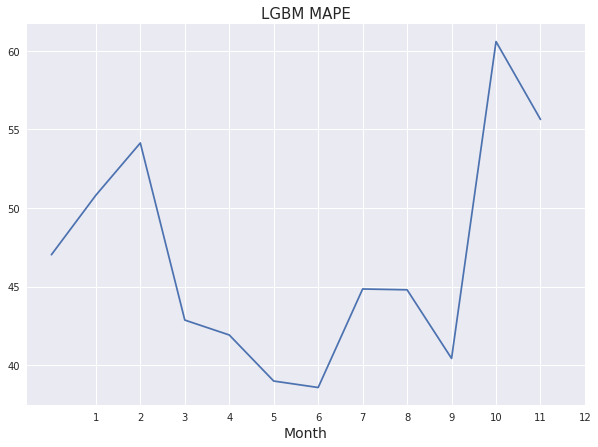

In [ ]:
# visualization
plt.figure(figsize = (10, 7))
plt.plot(mape1['val_mape'])
plt.xlabel('Month', fontsize = 14)
plt.xticks(np.arange(1,13,1))
plt.title('LGBM MAPE', fontsize = 15)
plt.show()


In [ ]:
'''
# visualization
plt.figure(figsize = (10, 7))
plt.plot(predsl)
plt.xlabel('Month', fontsize = 14)
plt.xticks(np.arange(1,13,1))
plt.title('LGBM PRED', fontsize = 15)
plt.show()
'''

In [ ]:
item_cat = [col for col in X_v3.columns if '상품군' in col]
item_cat = [ '상품군_가구',
            '상품군_가전',
            '상품군_건강기능',
            '상품군_농수축',
            '상품군_생활용품',
            '상품군_속옷',
            '상품군_의류',
            '상품군_이미용',
            '상품군_잡화',
            '상품군_주방',
            '상품군_침구']

* CV with category

In [ ]:
# lgbm with ver4 data
# CV with month

def lgbm_model(X, y, params) : 

    mape = {'val_mape' : [], 'test_mape' : []}
    
    # 실제 예측 값 
    preds = {'val_preds' : [], 'test_preds' : []}    
    lgbm_feat_imp = [0] * len(X.columns)

    
    for item in item_cat:
        train_idx = X.loc[X[item] != ].index
        test_idx = X.loc[X['방송월'] == i].index
        

        x_train = X.loc[train_idx]
        y_train = y.loc[x_train.index]
        
        test = X.loc[test_idx]
        
        x_val = test.loc[((test['방송일'] > 0) & (test['방송일'] < 8)) | ((test['방송일'] > 15) & (test['방송일'] < 24))]
        y_val = y.loc[x_val.index]
        
        x_test = test.loc[((test['방송일'] > 7) & (test['방송일'] < 16)) | ((test['방송일'] > 23) & (test['방송일'] < 32))]
        y_test = y.loc[x_test.index] 
        
        
        train_T = lgb.Dataset(x_train.values, label=y_train.values) 
        val_T = lgb.Dataset(x_val.values, label=y_val.values)        

        # 유형별로 train 및 validation & test
        model = lgb.train(params, train_T, 10000, valid_sets = val_T, verbose_eval=False, early_stopping_rounds=500)
        val_pred = model.predict(x_val.values)
        y_pred = model.predict(x_test.values)  
        
        
        preds['val_preds'].append(np.exp(val_pred))
        preds['test_preds'].append(np.exp(y_pred))
        
        
        mape['val_mape'].append(mean_absolute_percentage_error(np.exp(y_val), np.exp(val_pred)))
        mape['test_mape'].append(mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred)))
        lgbm_feat_imp += model.feature_importance()        
        
        for m, arg in enumerate(zip(mape['val_mape'], mape['test_mape']), 1):
            print(f'{m}월\t', '[val]:', arg[0], '\t[test]', arg[1]) 
     
    
    return mape, preds, lgbm_feat_imp


In [ ]:
def split(self, df, drop_cols, y_col):
            skf = StratifiedKFold(n_splits=5, shuffle=True)
            for train_index, test_index in skf.split(df, df['skf']):
                
                train_x = df.loc[train_index].drop(drop_cols, axis=1)
                train_y = df.loc[train_index][y_col]

                valid_x = df.loc[test_index].drop(drop_cols, axis=1)
                valid_y = df.loc[test_index][y_col]
            
                yield train_x, train_y, valid_x, valid_y

### 3. Ensemble
- voting
- bagging
- stacking